In [3]:
%matplotlib inline

# Gradient Descent Optimization With AMSGrad From Scratch

Gradient descent is an optimization algorithm that follows the negative gradient of an objective function in order to locate the minimum of the function.

A limitation of vanilla gradient descent is that a single step size (learning rate) is used for all input variables. Extensions to gradient descent like the <b>Adaptive Movement Estimation (Adam)</b> algorithm use a separate step size for each input variable but may result in a step size that rapidly decreases to very small values.

<b>AMSGrad</b> is an extension to the Adam version of gradient descent that attempts to improve the convergence properties of the algorithm, avoiding large abrupt changes in the learning rate for each input variable.

Gradient Descent is technically referred to as a first-order optimization algorithm as it explicitly makes use of the first-order derivative of the target objective function. It is the first-order derivative for a multivariate objective function.

The gradient descent algorithm requires a starting point (x) in the problem, such as a randomly selected point in the input space.

The derivative is then calculated and a step is taken in the input space that is expected to result in a downhill movement in the target function, assuming we are minimizing the target function.

A downhill movement is made by first calculating how far to move in the input space, calculated as the step size (called alpha or the learning rate) multiplied by the gradient. This is then subtracted from the current point, ensuring we move against the gradient, or down the target function.

$x(t) = x(t-1) -step\_size* f'{x(t)}$

The steeper the objective function at a given point, the larger the magnitude of the gradient, and in turn, the larger the step taken in the search space. The size of the step taken is scaled using a step size hyperparameter.

## AMSGrad Optimization Algorithm

AMSGrad algorithm is an extension to the Adaptive Movement Estimation (Adam) optimization algorithm. More broadly, is an extension to the Gradient Descent Optimization algorithm.

Generally, Adam automatically adapts a separate step size (learning rate) for each parameter in the optimization problem.

A limitation of Adam is that it can both decrease the step size when getting close to the optima, which is good, but it also increases the step size in some cases, which is bad.

<b>The Algorithm</b><br>
First, we must maintain a first and second moment vector as well as a max second moment vector for each parameter being optimized as part of the search, referred to as m and v (Geek letter nu but we will use v), and $\hat{n}$ respectively.

They are initialized to 0.0 at the start of the search.

$m=0$ <br> $n=0$ <br> $\hat{n}=0$ <br>

The algorithm is executed iteratively over time t starting at $t=1$, and each iteration involves calculating a new set of parameter values x, e.g. going from $x(t-1)$ to $x(t)$.

Lets focus on updating one parameter. This generalizes to updating all parameters via vector operations.

<b>Step one</b>, the gradients (partial derivatives) are calculated for the current time step.

$g(t) = f'(x(t-1))$

Next, the first moment vector is updated using the <b>gradient and a hyperparameter beta1</b>.

$m(t) = \beta1(t) * m(t-1) + (1 – \beta1(t)) * g(t)$

The beta1 hyperparameter can be held constant or can be decayed exponentially over the course of the search, such as:

$\beta1(t) = \beta1(t)^t$

Or, alternately:

$\beta1(t) = \beta1 / t$

The second moment vector is updated using the <b>square of the gradient and a hyperparameter beta2</b>.

$v(t) = \beta2 * v(t-1) + (1 – \beta2) * g(t)^2$

Next, the maximum for the second moment vector is updated.

$\hat{n}(t) = max(\hat{n}(t-1), v(t))$

Where max() calculates the maximum of the provided values.

The parameter value can then be updated using the <b>calculated terms and the step size hyperparameter alpha</b>.

$x(t) = x(t-1)  –  \dfrac{\alpha(t) * m(t)}{\sqrt{vhat(t)}}$


The step size may also be held constant or decayed exponentially.

To review, there are three hyperparameters for the algorithm; they are:

$\bullet$<b>alpha</b>: Initial step size (learning rate), a typical value is 0.002.<br>
$\bullet$<b>beta1</b>: Decay factor for first momentum, a typical value is 0.9.<br>
$\bullet$<b>beta2</b>: Decay factor for infinity norm, a typical value is 0.999.<br>

## Implementation

### Gradient Descent With AMSGrad - Two-Dimensional Test Problem


In [39]:
from math import sqrt
from numpy import asarray
from numpy.random import rand
from numpy.random import seed

We will use a simple two-dimensional function that sums thr squares the input of each dimension and define the range of valid inputs from -1.0 to 1.0.

In [4]:
#objective function

def obj_func(x, y):
    return x**2 + y**2

Creating a three-dimensional plot of the dataset to get a feeling for the curvature of the response surface.

In [5]:
# 3d plot of the test function
from numpy import arange, meshgrid
from matplotlib import pyplot

In [15]:
# define range for input
r_min, r_max = -1.0, 1.0
# sample input range uniformly at 0.1 increments
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = obj_func(x, y)

In [16]:
xaxis.shape, x.shape, results.shape

((20,), (20, 20), (20, 20))

<ipython-input-31-aa1a7d8d4968>:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis = fig.gca(projection='3d')


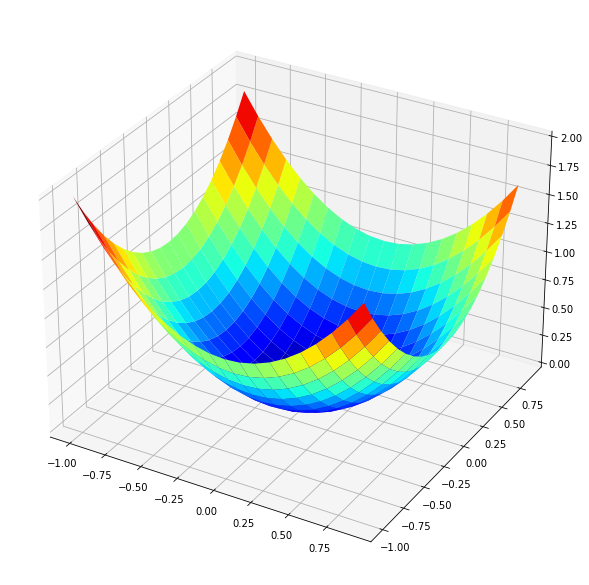

In [31]:
# create a surface plot with the jet color scheme
fig = pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
axis = fig.gca(projection='3d')
axis.plot_surface(x, y, results, cmap='jet')
# show the plot
pyplot.show()
#Save figure
#fig.savefig('test2png.png', dpi=100)

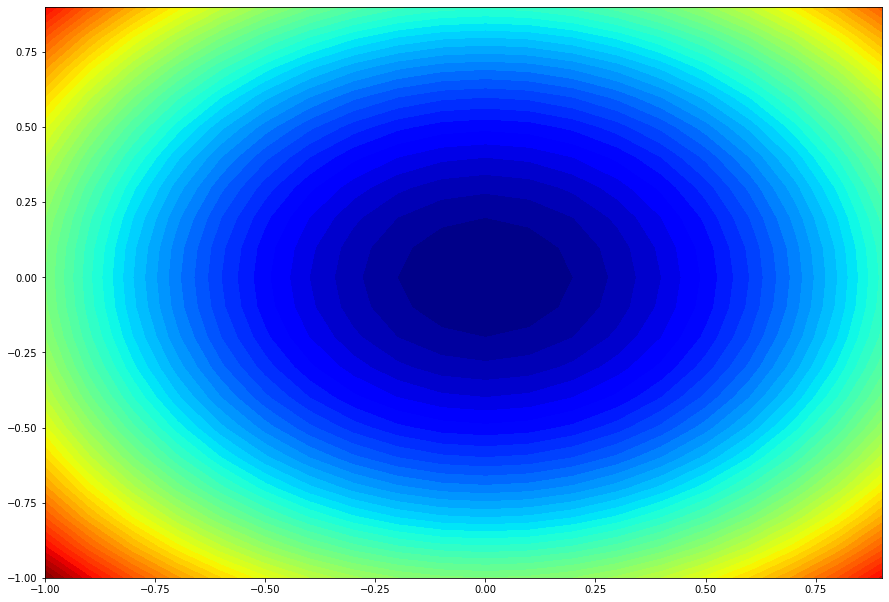

In [35]:
# contour plot of the test function
# create a filled contour plot with 50 levels and jet color scheme
pyplot.figure(figsize=(15, 10.5))
pyplot.contourf(x, y, results, levels=50, cmap='jet')
# show the plot
pyplot.show()

In [36]:
# derivative of objective function
def derivative(x, y):
    return asarray([x * 2.0, y * 2.0])

Now we can implement gradient descent optimization with AMSGrad.

First, we select a random point in the bounds of the problem as a starting point for the search.

This assumes we have an array that defines the bounds of the search with one row for each dimension and the first column defines the minimum and the second column defines the maximum of the dimension.

In [38]:
# gradient descent algorithm with amsgrad
def amsgrad(objective, derivative, bounds, n_iter, alpha, beta1, beta2):
    # generate an initial point
    x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # initialize moment vectors
    m = [0.0 for _ in range(bounds.shape[0])]
    v = [0.0 for _ in range(bounds.shape[0])]
    vhat = [0.0 for _ in range(bounds.shape[0])]
    # run the gradient descent
    for t in range(n_iter):
        # calculate gradient g(t)
        g = derivative(x[0], x[1])
        # update variables one at a time
        for i in range(x.shape[0]):
            # m(t) = beta1(t) * m(t-1) + (1 - beta1(t)) * g(t)
            m[i] = beta1**(t+1) * m[i] + (1.0 - beta1**(t+1)) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = (beta2 * v[i]) + (1.0 - beta2) * g[i]**2
            # vhat(t) = max(vhat(t-1), v(t))
            vhat[i] = max(vhat[i], v[i])
            # x(t) = x(t-1) - alpha(t) * m(t) / sqrt(vhat(t)))
            x[i] = x[i] - alpha * m[i] / (sqrt(vhat[i]) + 1e-8)
        # evaluate candidate point
        score = objective(x[0], x[1])
        # report progress
        print('>%d f(%s) = %.5f' % (t, x, score))
    return [x, score]

In [54]:
# seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 100
# steps size
alpha = 0.007
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.99
# perform the gradient descent search with amsgrad
best, score = amsgrad(obj_func, derivative, bounds, n_iter, alpha, beta1, beta2)

>0 f([-0.15895599  0.43364899]) = 0.21332
>1 f([-0.1456267   0.42024471]) = 0.19781
>2 f([-0.12718612  0.40142256]) = 0.17732
>3 f([-0.1059087   0.37903407]) = 0.15488
>4 f([-0.08436882  0.35511103]) = 0.13322
>5 f([-0.06472526  0.33132988]) = 0.11397
>6 f([-0.04828292  0.308769  ]) = 0.09767
>7 f([-0.03542855  0.2879325 ]) = 0.08416
>8 f([-0.02586459  0.26891823]) = 0.07299
>9 f([-0.01896889  0.25160623]) = 0.06367
>10 f([-0.01405356  0.23579768]) = 0.05580
>11 f([-0.01053367  0.22129107]) = 0.04908
>12 f([-0.00797833  0.20791183]) = 0.04329
>13 f([-0.00609309  0.19551744]) = 0.03826
>14 f([-0.00468215  0.18399303]) = 0.03388
>15 f([-0.00361438  0.17324537]) = 0.03003
>16 f([-0.00279971  0.16319753]) = 0.02664
>17 f([-0.00217446  0.15378504]) = 0.02365
>18 f([-0.00169245  0.14495305]) = 0.02101
>19 f([-0.00131959  0.13665426]) = 0.01868
>20 f([-0.00103038  0.12884748]) = 0.01660
>21 f([-0.00080554  0.12149642]) = 0.01476
>22 f([-0.00063043  0.11457005]) = 0.01313
>23 f([-0.00049383  0

In [55]:
# summarize the result
print('Done!')
print('f(%s) = %f' % (best, score))

Done!
f([-6.78226299e-12  1.27905163e-03]) = 0.000002


## Visualization of AMSGrad Optimization

In [56]:
# gradient descent algorithm with amsgrad
def amsgrad(objective, derivative, bounds, n_iter, alpha, beta1, beta2):
    solutions = list()
    # generate an initial point
    x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # initialize moment vectors
    m = [0.0 for _ in range(bounds.shape[0])]
    v = [0.0 for _ in range(bounds.shape[0])]
    vhat = [0.0 for _ in range(bounds.shape[0])]
    # run the gradient descent
    for t in range(n_iter):
        # calculate gradient g(t)
        g = derivative(x[0], x[1])
        # update variables one at a time
        for i in range(x.shape[0]):
            # m(t) = beta1(t) * m(t-1) + (1 - beta1(t)) * g(t)
            m[i] = beta1**(t+1) * m[i] + (1.0 - beta1**(t+1)) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = (beta2 * v[i]) + (1.0 - beta2) * g[i]**2
            # vhat(t) = max(vhat(t-1), v(t))
            vhat[i] = max(vhat[i], v[i])
            # x(t) = x(t-1) - alpha(t) * m(t) / sqrt(vhat(t)))
            x[i] = x[i] - alpha * m[i] / (sqrt(vhat[i]) + 1e-8)
        # evaluate candidate point
        score = objective(x[0], x[1])
        # keep track of all solutions
        solutions.append(x.copy())
        # report progress
        print('>%d f(%s) = %.5f' % (t, x, score))
    return solutions

In [58]:
# seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 100
# steps size
alpha = 0.007
# factor for average gradient
beta1 = 0.9
# factor for average squared gradient
beta2 = 0.99
# perform the gradient descent search with amsgrad
solutions = amsgrad(obj_func, derivative, bounds, n_iter, alpha, beta1, beta2)

>0 f([-0.15895599  0.43364899]) = 0.21332
>1 f([-0.1456267   0.42024471]) = 0.19781
>2 f([-0.12718612  0.40142256]) = 0.17732
>3 f([-0.1059087   0.37903407]) = 0.15488
>4 f([-0.08436882  0.35511103]) = 0.13322
>5 f([-0.06472526  0.33132988]) = 0.11397
>6 f([-0.04828292  0.308769  ]) = 0.09767
>7 f([-0.03542855  0.2879325 ]) = 0.08416
>8 f([-0.02586459  0.26891823]) = 0.07299
>9 f([-0.01896889  0.25160623]) = 0.06367
>10 f([-0.01405356  0.23579768]) = 0.05580
>11 f([-0.01053367  0.22129107]) = 0.04908
>12 f([-0.00797833  0.20791183]) = 0.04329
>13 f([-0.00609309  0.19551744]) = 0.03826
>14 f([-0.00468215  0.18399303]) = 0.03388
>15 f([-0.00361438  0.17324537]) = 0.03003
>16 f([-0.00279971  0.16319753]) = 0.02664
>17 f([-0.00217446  0.15378504]) = 0.02365
>18 f([-0.00169245  0.14495305]) = 0.02101
>19 f([-0.00131959  0.13665426]) = 0.01868
>20 f([-0.00103038  0.12884748]) = 0.01660
>21 f([-0.00080554  0.12149642]) = 0.01476
>22 f([-0.00063043  0.11457005]) = 0.01313
>23 f([-0.00049383  0

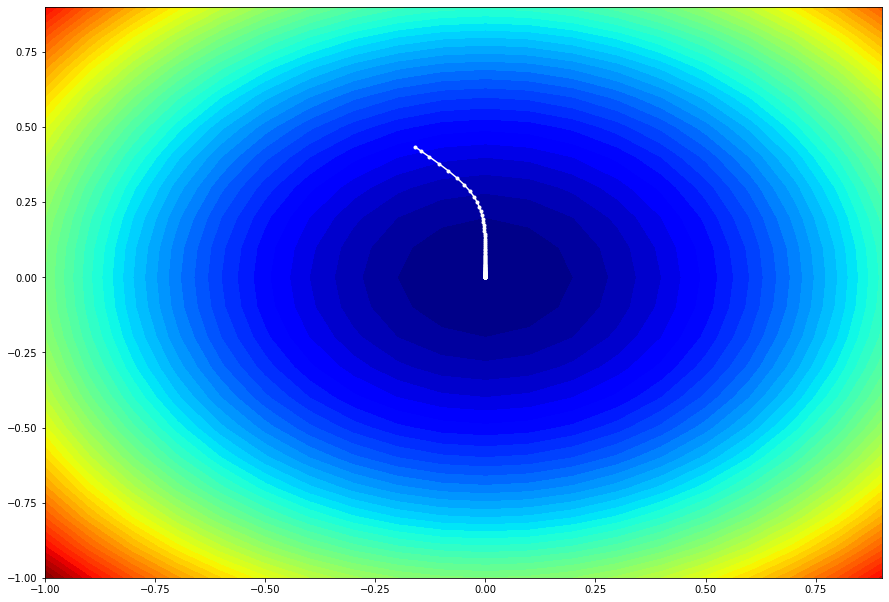

In [61]:
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = obj_func(x, y)
# create a filled contour plot with 50 levels and jet color scheme
pyplot.figure(figsize=(15, 10.5))
pyplot.contourf(x, y, results, levels=50, cmap='jet')
# plot the sample as black circles
solutions = asarray(solutions)
pyplot.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')
# show the plot
pyplot.show()